**1. Imports**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv


* **2. Load data**

In [2]:
file_train_data = pd.read_csv("/kaggle/input/playground-series-s3e17/train.csv", index_col = "id")
file_test_data = pd.read_csv("/kaggle/input/playground-series-s3e17/test.csv", index_col = "id")
file_train_data.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,,
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [3]:
file_test_data.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,
136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [4]:
X_train = file_train_data.copy()
X_test = file_test_data.copy()
X_train.drop(['Machine failure', 'Product ID'], axis=1, inplace=True)
X_test.drop(['Product ID'], axis=1, inplace=True)
y = file_train_data['Machine failure']
X_train

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,
0,L,300.6,309.6,1596,36.1,140,0,0,0,0,0
1,M,302.6,312.1,1759,29.1,200,0,0,0,0,0
2,L,299.3,308.5,1805,26.5,25,0,0,0,0,0
3,L,301.0,310.9,1524,44.3,197,0,0,0,0,0
4,M,298.0,309.0,1641,35.4,34,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
136424,M,300.1,311.4,1530,37.5,210,0,0,0,0,0
136425,H,297.5,308.5,1447,49.1,2,0,0,0,0,0
136426,L,300.5,311.8,1524,38.5,214,0,0,0,0,0


In [5]:
y

id
0         0
1         0
2         0
3         0
4         0
         ..
136424    0
136425    0
136426    0
136427    0
136428    0
Name: Machine failure, Length: 136429, dtype: int64

* **3. EDA**

In [6]:
X_train.describe(include = 'all')

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
count,136429,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
unique,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,95354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,299.862776,309.941070,1520.331110,40.348643,104.408901,0.001554,0.005160,0.002397,0.003958,0.002258
std,NaN,1.862247,1.385173,138.736632,8.502229,63.965040,0.039389,0.071649,0.048899,0.062789,0.047461
min,NaN,295.300000,305.800000,1181.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,300.000000,310.000000,1493.000000,40.400000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,301.200000,310.900000,1580.000000,46.100000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
X_train.nunique(axis=0, dropna=True)

Type                         3
Air temperature [K]         95
Process temperature [K]     81
Rotational speed [rpm]     952
Torque [Nm]                611
Tool wear [min]            246
TWF                          2
HDF                          2
PWF                          2
OSF                          2
RNF                          2
dtype: int64

In [8]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum().values*100
    sum['missing%'] = (df.isna().sum().values*100)/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    #sum['skew'] = df.skew().values
    desc = pd.DataFrame(df.describe().T)
    sum['min'] = desc['min']
    sum['max'] = desc['max']
    sum['mean'] = desc['mean']
    return sum

summary(X_train).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count,min,max,mean
Type,object,0,0.000000,3,136429,nan,nan,nan
Air temperature [K],float64,0,0.000000,95,136429,295.300000,304.400000,299.862776
Process temperature [K],float64,0,0.000000,81,136429,305.800000,313.800000,309.941070
Rotational speed [rpm],int64,0,0.000000,952,136429,1181.000000,2886.000000,1520.331110
Torque [Nm],float64,0,0.000000,611,136429,3.800000,76.600000,40.348643
Tool wear [min],int64,0,0.000000,246,136429,0.000000,253.000000,104.408901
TWF,int64,0,0.000000,2,136429,0.000000,1.000000,0.001554
HDF,int64,0,0.000000,2,136429,0.000000,1.000000,0.005160
PWF,int64,0,0.000000,2,136429,0.000000,1.000000,0.002397
OSF,int64,0,0.000000,2,136429,0.000000,1.000000,0.003958


In [9]:
summary(X_test).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count,min,max,mean
Type,object,0,0.000000,3,90954,nan,nan,nan
Air temperature [K],float64,0,0.000000,92,90954,295.300000,304.400000,299.859493
Process temperature [K],float64,0,0.000000,84,90954,305.700000,313.800000,309.939375
Rotational speed [rpm],int64,0,0.000000,946,90954,1168.000000,2886.000000,1520.528179
Torque [Nm],float64,0,0.000000,595,90954,3.800000,76.600000,40.335191
Tool wear [min],int64,0,0.000000,246,90954,0.000000,253.000000,104.293962
TWF,int64,0,0.000000,2,90954,0.000000,1.000000,0.001473
HDF,int64,0,0.000000,2,90954,0.000000,1.000000,0.005343
PWF,int64,0,0.000000,2,90954,0.000000,1.000000,0.002353
OSF,int64,0,0.000000,2,90954,0.000000,1.000000,0.003870


/tmp/ipykernel_20/1908155217.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


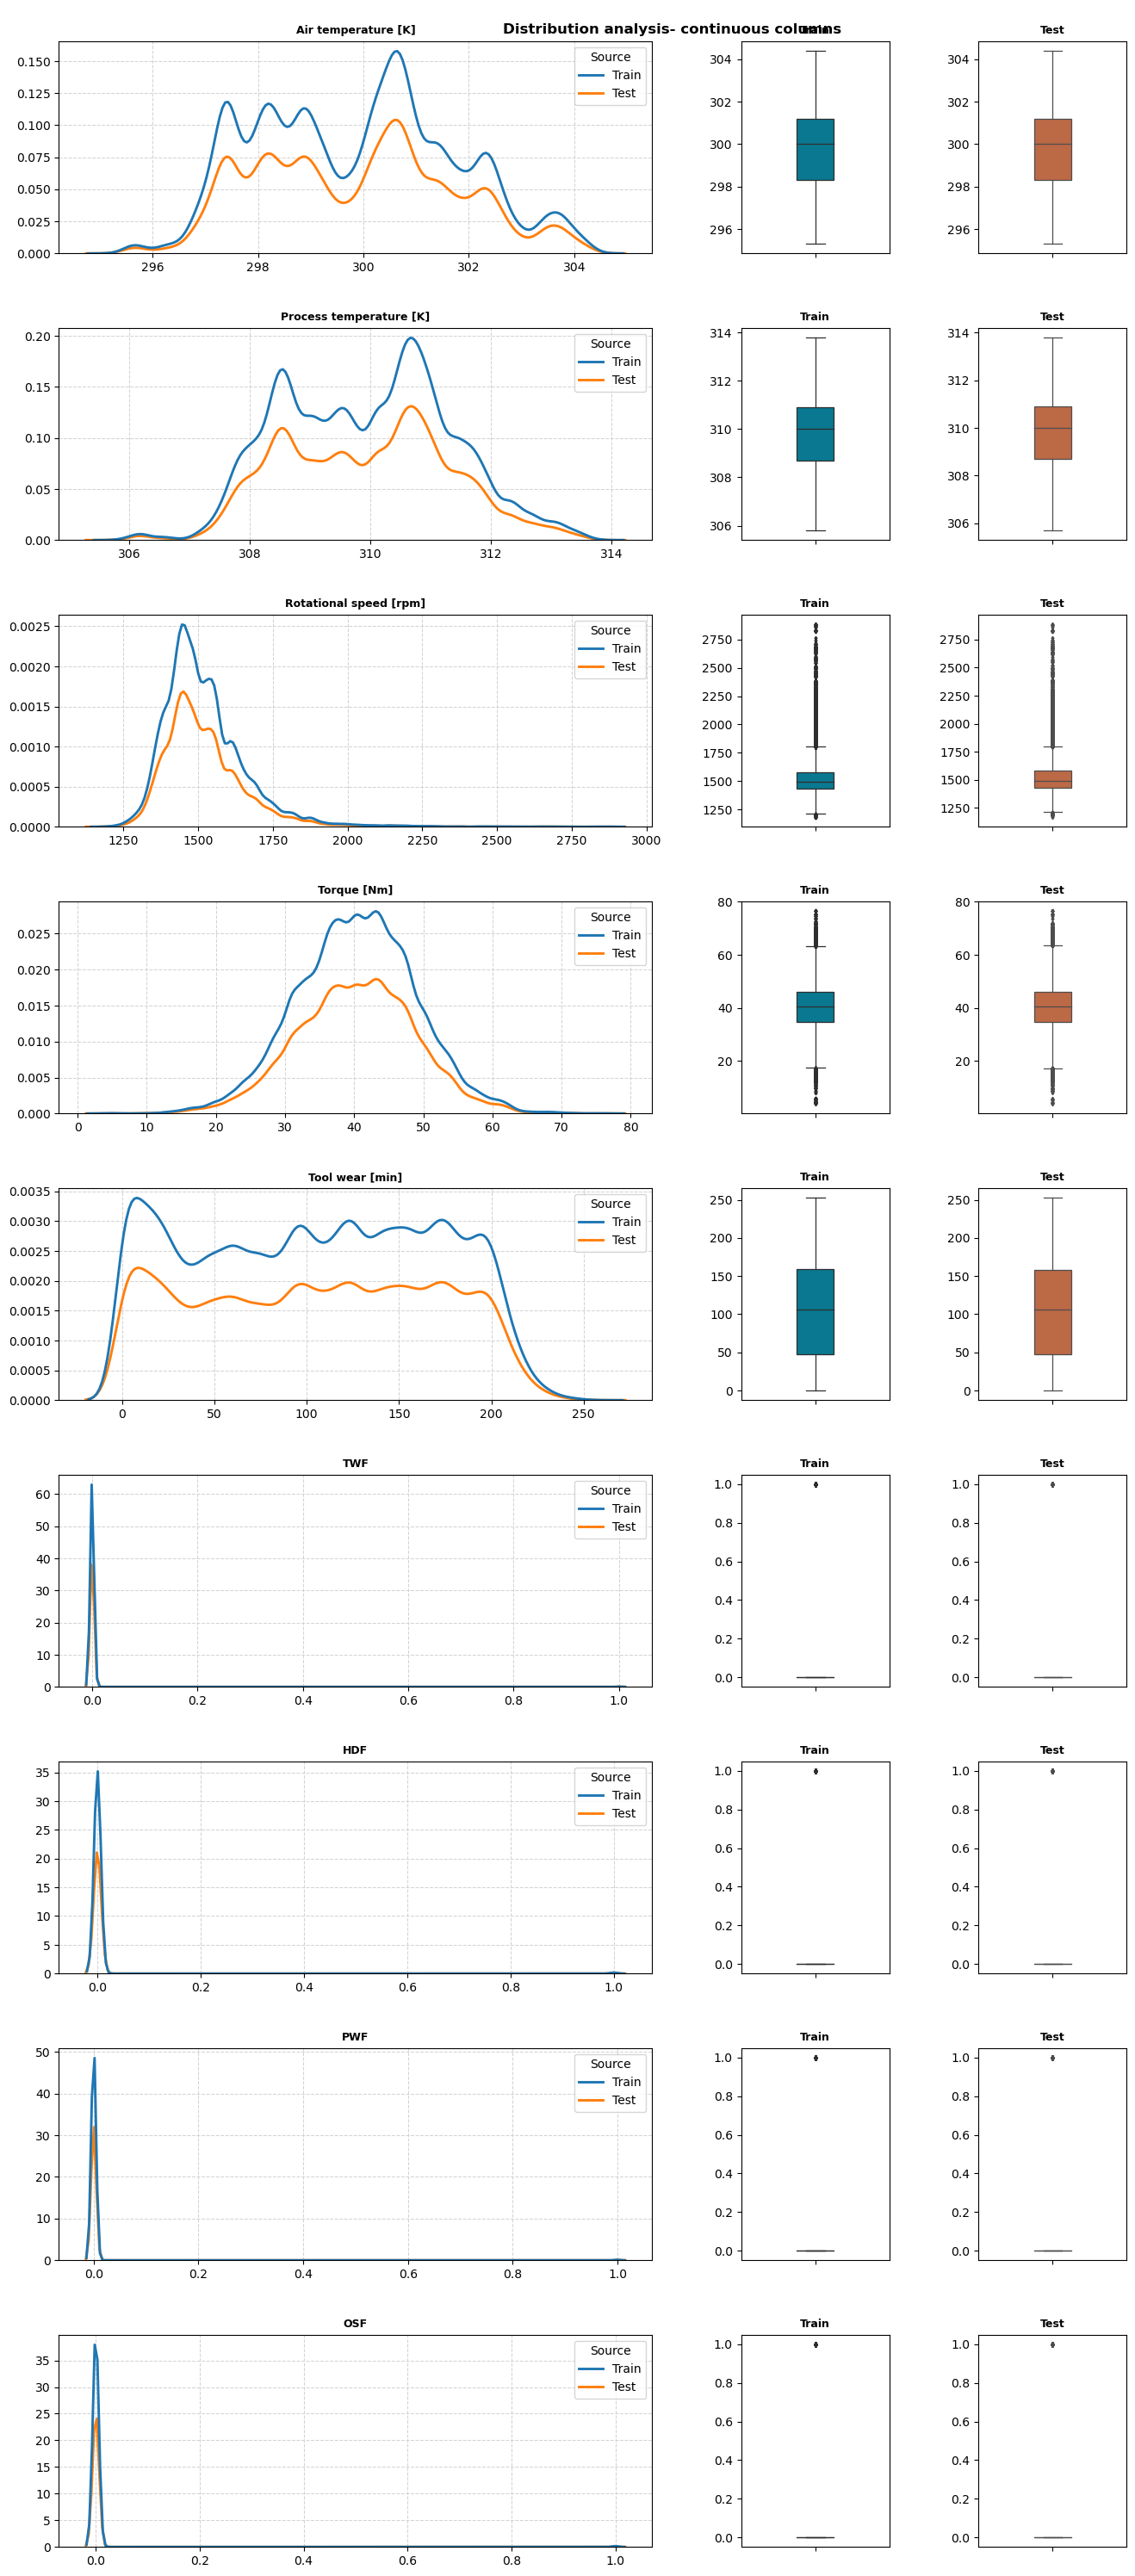

In [10]:
#from YANG ZHOU: https://www.kaggle.com/code/yaaangzhou/en-playground-s3-e20-eda-modeling#-0.-Imports-
num = X_train.columns.tolist()[1:-1]
df = pd.concat([X_train[num].assign(Source = 'Train'), 
                X_test[num].assign(Source = 'Test')], 
               axis=0, ignore_index = True);

fig, axes = plt.subplots(len(num), 3 ,figsize = (16, len(num) * 4.2), 
                         gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20]});

for i,col in enumerate(num):
    ax = axes[i,0];
    sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', ax = ax, linewidth = 2.1)
    ax.set_title(f"\n{col}",fontsize = 9, fontweight= 'bold');
    ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75);
    ax.set(xlabel = '', ylabel = '');
    ax = axes[i,1];
    sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25,saturation = 0.90, linewidth = 0.90, fliersize= 2.25, color = '#037d97',
                ax = ax);
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Train",fontsize = 9, fontweight= 'bold');

    ax = axes[i,2];
    sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, fliersize= 2.25,
                saturation = 0.6, linewidth = 0.90, color = '#E4591E',
                ax = ax); 
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Test",fontsize = 9, fontweight= 'bold');
    
plt.suptitle(f"\nDistribution analysis- continuous columns\n",fontsize = 12, fontweight= 'bold',
             y = 0.89, x = 0.57);
plt.tight_layout();
plt.show();

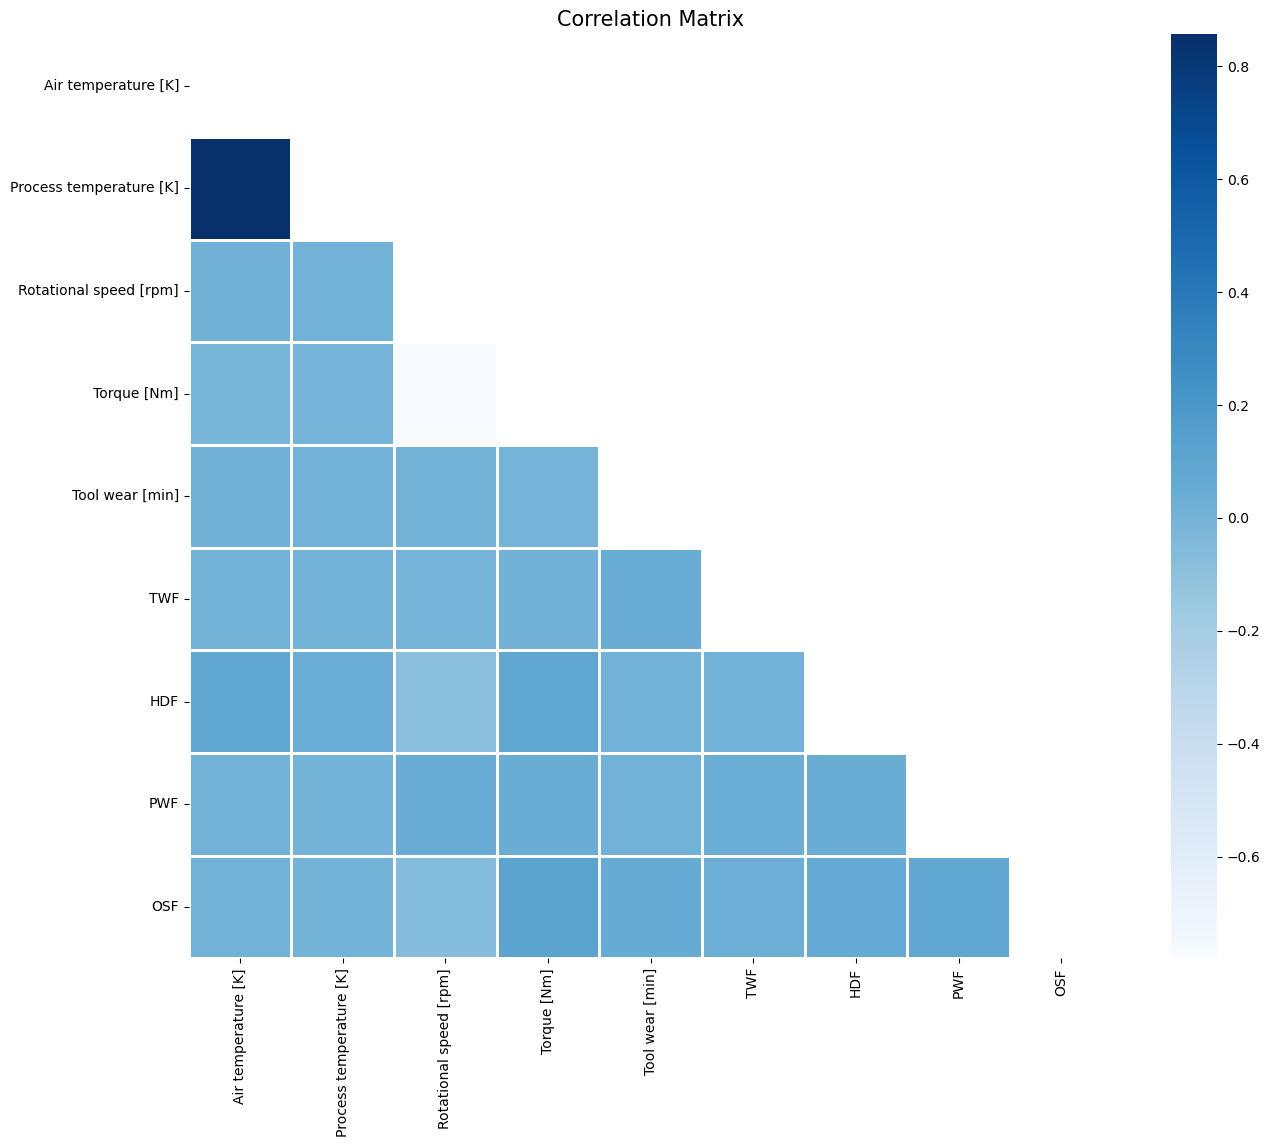

In [11]:
# Correlation

corr_matrix = X_train[num].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
plt.title('Correlation Matrix', fontsize=15)
plt.show()

Strong correlation between Process temp and Air temp and Torque/Rotational speed - might consider removing one of the columns

* **4. Preprocessing/making pipelines**

In [12]:
X_train

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,
0,L,300.6,309.6,1596,36.1,140,0,0,0,0,0
1,M,302.6,312.1,1759,29.1,200,0,0,0,0,0
2,L,299.3,308.5,1805,26.5,25,0,0,0,0,0
3,L,301.0,310.9,1524,44.3,197,0,0,0,0,0
4,M,298.0,309.0,1641,35.4,34,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
136424,M,300.1,311.4,1530,37.5,210,0,0,0,0,0
136425,H,297.5,308.5,1447,49.1,2,0,0,0,0,0
136426,L,300.5,311.8,1524,38.5,214,0,0,0,0,0


In [13]:
#from DODAT : https://www.kaggle.com/code/drissdo23/binary-classification-data-pipeline
num_cols = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]']
binary_cols = [
    'TWF',
    'HDF',
    'PWF',
    'OSF',
    'RNF'
]
cat_cols = ['Type']

In [14]:
cat_pipeline = Pipeline(steps=
                         [('imputer',SimpleImputer(strategy="most_frequent")),
                          ('onehot', OneHotEncoder(handle_unknown='ignore')),
                          ])

num_pipeline = Pipeline(steps=
                         [('imputer',KNNImputer(n_neighbors=5)),
                          ('scaler', MinMaxScaler()),
                          ])

binary_pipeline = Pipeline(steps=
                           [('binary_encoder', OneHotEncoder(drop='if_binary'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num',num_pipeline,num_cols),
        ('cate',cat_pipeline,cat_cols),
        ('binayr',binary_pipeline,binary_cols)
    ]
)

clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(n_estimators=500,learning_rate=0.1))
    ]
)


* **5. Training model**

In [15]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_train, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [16]:
clf.fit(X_train_full, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Air temperature [K]',
                                                   'Process temperature [K]',
                                                   'Rotational speed [rpm]',
                                                   'Torque [Nm]',
                                                   'Tool wear [min]']),
                                                 ('cate',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unkn...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=500,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [17]:
preds = clf.predict(X_valid_full)

print(f"Accuracy on train: {accuracy_score(list(y_valid), list(preds)):.2f}")

Accuracy on train: 1.00


In [18]:
submition = clf.predict(X_test)

In [19]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'Machine failure': submition})
output.to_csv('submission.csv', index=False)